# Dependencies

In [1]:
import numpy as np
import scipy as sp
import netCDF4 as nC4
import scipy.signal
import pdfo
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("paper",font_scale=1.2)
import statsmodels.api as sm
LOWESS = sm.nonparametric.lowess
import eofs
import xrft
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import xarray as xr
import os
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
import glob
import datetime
import time
import multiprocessing
import tqdm
import cmocean
import met_brewer
import palettable
from shapely.geometry.polygon import LinearRing
import copy
import warnings

import pyarrow as pa
import pyarrow.parquet as pq

from IPython.display import display, clear_output

## get my stats functions
from mystatsfunctions import OLSE,LMoments
from moarpalettes import get_palette

from fair import *

## Matplotlib rcparams setup:
plt.style.use('/home/leachl/Documents/Thesis/ancil/figure-style.mplstyle')

%matplotlib inline

In [2]:
## plotting functions:

def add_lat_lon_ticks(ax,lat=False,lon=False):
    if not lon is False:
        ax.set_xticks(lon, crs=crs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
    if not lat is False:
        ax.set_yticks(lat, crs=crs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

## Define functions

In [3]:
## function for hacking seaborn's catplot to make it pretty

def hack_catplot_range(x,y,hue,ci=66,dodge=False,hue_order=False,palette=False,**kwargs):
    
    x = x.astype(str)
    
    # calculate desired quantiles
    quantiles = [0.5-ci/200 , 0.5+ci/200]
    
    # calculate x data
    plot_x = dict(zip(x.unique(),np.arange(x.unique().size)))
    
    # if hue order
    if not hue_order:
        hue_order = hue.unique().tolist()
    
    hue_number = len(hue_order)
    
    # if dodge
    if dodge:
        plot_x_dodge = dict(zip(hue_order,np.linspace(-dodge/2,dodge/2,hue_number)))
    else:
        plot_x_dodge = dict(zip(hue.unique(),np.zeros(hue_number)))
    
    # groupby x,hue and plot
    for i,((x_level,hue_level),gr) in enumerate(y.groupby([x,hue])):
        
        if palette:
            kwargs['color'] = palette[hue_order.index(hue_level)]
        
        _y = np.nanquantile(gr.values,quantiles,interpolation='nearest')
        ## replace infs
        _y = np.where(np.isinf(_y),999999,_y)
        
        _x = plot_x[x_level] + plot_x_dodge[hue_level]
        
        plt.vlines(_x,*_y,lw=matplotlib.rcParams['lines.linewidth']*1.8,**kwargs)

In [4]:
palette = get_palette.IBM_color_blind().to_sn_palette()
## textwidth of Thesis
textwidth = 5.848611111111111

# Retrieve data

Get AWI.

In [5]:
## HadCRUT5
HC5 = xr.open_dataset('./ancil/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.nc')
HC5 = HC5.tas_mean.to_pandas()
HC5.index = HC5.index.year

## ERF components from AR6
erf_ar6 = pd.read_csv('./ancil/AR6_ERF_1750-2019.csv',index_col=0)

## ant / nat FaIR run
fair_erf = pd.DataFrame(index=erf_ar6.index,columns=pd.MultiIndex.from_product([['ant','aer','nat'],['forcing']]),data=pd.concat([erf_ar6.loc[:,'total_anthropogenic']-erf_ar6.loc[:,'aerosol'],erf_ar6.loc[:,'aerosol'],erf_ar6.loc[:,'total_natural']],axis=1).values)
fair_emms = return_empty_emissions(start_year=1750,end_year=2019,scen_names=['ant','aer','nat'])
fair_temps = run_FaIR(emissions_in=fair_emms,forcing_in=fair_erf)['T'].loc[1850:]

## regress HadCRUT5 onto FaIR temperature output & define anthropogenic warming index
X = np.column_stack([np.ones(fair_temps.index.size),fair_temps])
Y = HC5.loc[1850:2019].values[:,None]
mlr = OLSE.multiple(Y)
mlr.fit(X)
AWI = ( mlr.B[1]*fair_temps.aer + mlr.B[2]*fair_temps.ant ).default

Integrating 3 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|o3', 'cfc114', 'cfc114|o3', 'cfc115', 'cfc115|o3', 'cfc11|o3', 'cfc12', 'cfc12|o3', 'ch2cl2', 'ch2cl2|o3', 'ch3ccl3', 'ch3ccl3|o3', 'chcl3', 'chcl3|o3', 'co', 'co|o3', 'halon1202', 'halon1202|o3', 'halon1211', 'halon1211|o3', 'halon1301', 'halon1301|o3', 'halon2402', 'halon2402|o3', 'hcfc141b', 'hcfc141b|o3', 'hcfc142b', 'hcfc142b|o3', 'hcfc22', 'hcfc22|o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|o3', 'methyl_bromide', 'methyl_bromide|o3', 'methyl_chloride', 'methyl_chloride|o3', 'nf3', 'nh3', 'nitrous_oxide', 'nitrous_oxide|o3', 'nmvoc', 'nmvoc|o3', 'nox', 'nox_avi'

100%|██████████| 269/269 [00:00<00:00, 3117.62 timestep/s]


Get E-Obs observations.

### fields

In [6]:
def preproc_eobs(ds):
    
    metric = ds.encoding['source'].split('/')[-1].split('_')[-1].split('.')[0]
    
    ds['time'] = ds.time.dt.year
    
    return ds.expand_dims({'metric':[metric]}).transpose('time',...)

EObs_paths = glob.glob('/home/leachl/Documents/Attribution/BAMs_2018_Europe_summer/Obsv_return/E_Obs_0.25deg_TX*av.nc')
EObs = xr.open_mfdataset(EObs_paths,combine='nested',concat_dim=['metric'],preprocess=preproc_eobs)

## remove unwanted metrics
EObs = EObs.sel(metric=['TX10av','TX1av','TX90av'])

In [7]:
## land-sea mask
EObs['lsm'] = (EObs.isnull().sum(['time','metric'])==0).tg

### regions

In [8]:
def preproc_eobs_rg(ds):
    
    ds = ds.copy()
    metric = ds.encoding['source'].split('/')[-1].split('_')[-2]
    RG = ds.encoding['source'].split('/')[-2]
    ds['time'] = ds.time.dt.year
    
    return ds.expand_dims({'metric':[metric],'region':[RG]}).transpose('time',...)

EObs_RG = xr.open_mfdataset('/home/leachl/Documents/Attribution/BAMs_2018_Europe_summer/Obsv_return/regions/*/E_Obs_0.25deg_TX*av_*.nc',preprocess=preproc_eobs_rg).sel(metric=['TX10av','TX1av','TX90av']).squeeze()

# Analysis

### get detrended series for variability estimate

#### field

In [9]:
## detrend observations using AWI
slr = OLSE.simple(EObs.tg.values)
slr.fit(AWI.loc[EObs.time.values].values[:,None,None,None])

### remove attributable trend, shifting to a pseudo-stationary 2018 climatology
EObs['tg_trend'] = (['metric','latitude','longitude'],slr.b1)
EObs['tg_dt'] = EObs.tg - (slr.pred() - slr.pred(AWI.loc[2018]))

#### regional

In [10]:
## detrend observations using AWI
slr = OLSE.simple(EObs_RG.tg.values)
slr.fit(AWI.loc[EObs_RG.time.values].values[:,None,None])

### remove attributable trend, shifting to a pseudo-stationary 2018 climatology
EObs_RG['tg_trend'] = (['metric','region'],slr.b1)
EObs_RG['tg_dt'] = EObs_RG.tg - (slr.pred() - slr.pred(AWI.loc[2018]))

## Temperature anomalies

In [11]:
EObs['tg_anom'] = EObs.tg - EObs.tg.sel(time=slice(1981,2010)).mean('time')
EObs_RG['tg_anom'] = EObs_RG.tg - EObs_RG.tg.sel(time=slice(1981,2010)).mean('time')

/home/leachl/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


''

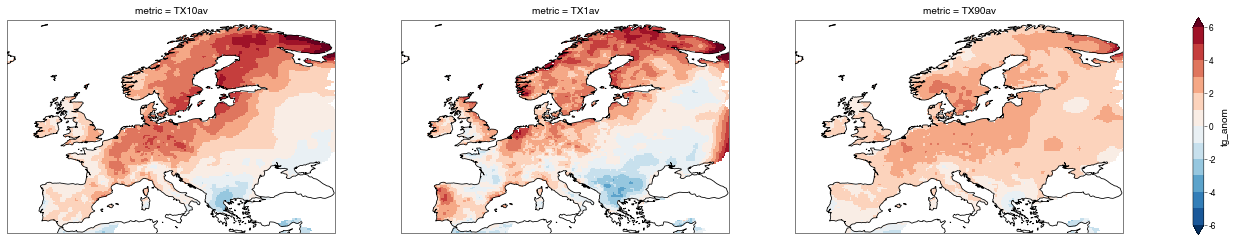

In [12]:
p = EObs.tg_anom.sel(time=2018).where(EObs.lsm).plot(figsize=(25,4),col='metric',cmap='RdBu_r',levels=np.linspace(-6,6,13),subplot_kws=dict(projection=crs.PlateCarree()),transform=crs.PlateCarree())

[a.set_extent([-15, 42, 35,72], crs=crs.PlateCarree()) for a in p.axes.flatten()]
[a.coastlines() for a in p.axes.flatten()]

''

''

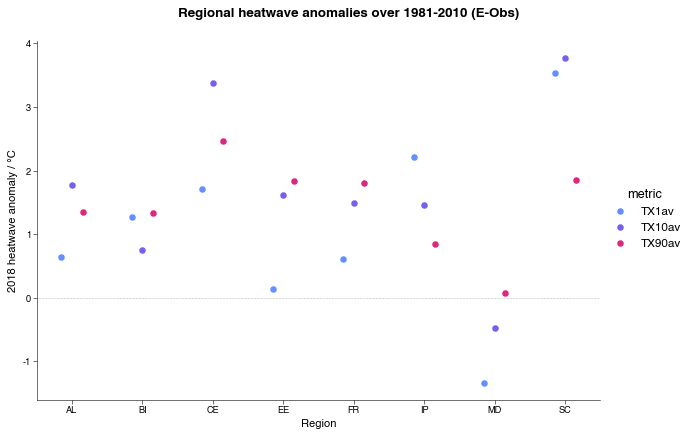

In [13]:
g=sn.catplot(data=EObs_RG.tg_anom.sel(time=2018).to_dataframe().tg_anom.reset_index(),y='tg_anom',x='region',hue='metric',hue_order=['TX1av','TX10av','TX90av'],kind='point',ci=None,estimator=np.nanmedian,join=False,dodge=0.3,palette=palette[:3],scale=1,aspect=1.5)    

g.set(ylabel='2018 heatwave anomaly / \N{DEGREE SIGN}C',xlabel='Region')
g.axes[0,0].axhline(0,ls=':',color='grey',lw=0.5)
g.fig.dpi=80
g.fig.patch.set_facecolor('xkcd:white')
g.fig.suptitle('Regional heatwave anomalies over 1981-2010 (E-Obs)',fontweight='bold',y=1.05)
''

## Temperature anomalies as sigma levels

In [14]:
EObs['tg_dt_sigma'] = (EObs.tg_dt-EObs.tg_dt.mean('time'))/EObs.tg_dt.std('time')
EObs_RG['tg_dt_sigma'] = (EObs_RG.tg_dt-EObs_RG.tg_dt.mean('time'))/EObs_RG.tg_dt.std('time')

In [15]:
sigma_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("OKeeffe1",met_brewer.met_brew(name="OKeeffe1", brew_type="continuous"))

/home/leachl/miniconda3/lib/python3.7/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


''

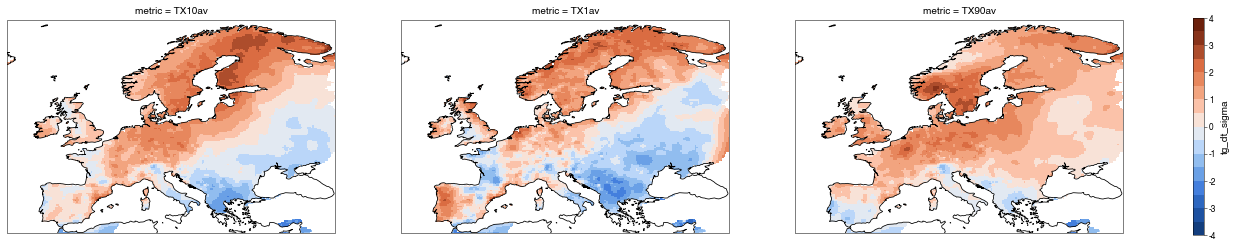

In [16]:
p = EObs.tg_dt_sigma.sel(time=2018).where(EObs.lsm).plot(figsize=(25,4),col='metric',cmap=sigma_cmap.reversed(),levels=np.linspace(-4,4,17),subplot_kws=dict(projection=crs.PlateCarree()),transform=crs.PlateCarree())

[a.set_extent([-15, 42, 35,72], crs=crs.PlateCarree()) for a in p.axes.flatten()]
[a.coastlines() for a in p.axes.flatten()]

''

''

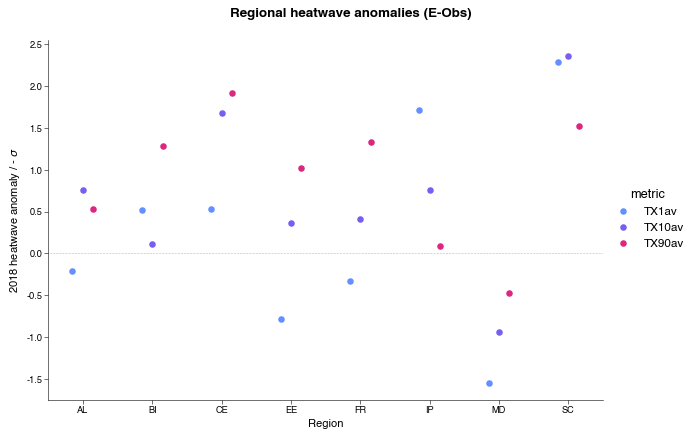

In [17]:
g=sn.catplot(data=EObs_RG.tg_dt_sigma.sel(time=2018).to_dataframe().tg_dt_sigma.reset_index(),y='tg_dt_sigma',x='region',hue='metric',hue_order=['TX1av','TX10av','TX90av'],kind='point',ci=None,estimator=np.nanmedian,join=False,dodge=0.3,palette=palette[:3],scale=1,aspect=1.5)    

g.set(ylabel='2018 heatwave anomaly / - $\sigma$',xlabel='Region')
g.axes[0,0].axhline(0,ls=':',color='grey',lw=0.5)
g.fig.dpi=80
g.fig.patch.set_facecolor('xkcd:white')
g.fig.suptitle('Regional heatwave anomalies (E-Obs)',fontweight='bold',y=1.05)
''

# The plot

In [18]:
# definition to rename metrics to conform to standards
rename_metrics = lambda x: 'TM'+x[2:-2]+'x'

/home/leachl/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/leachl/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/leachl/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/leachl/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/leachl/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/leachl/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide

''

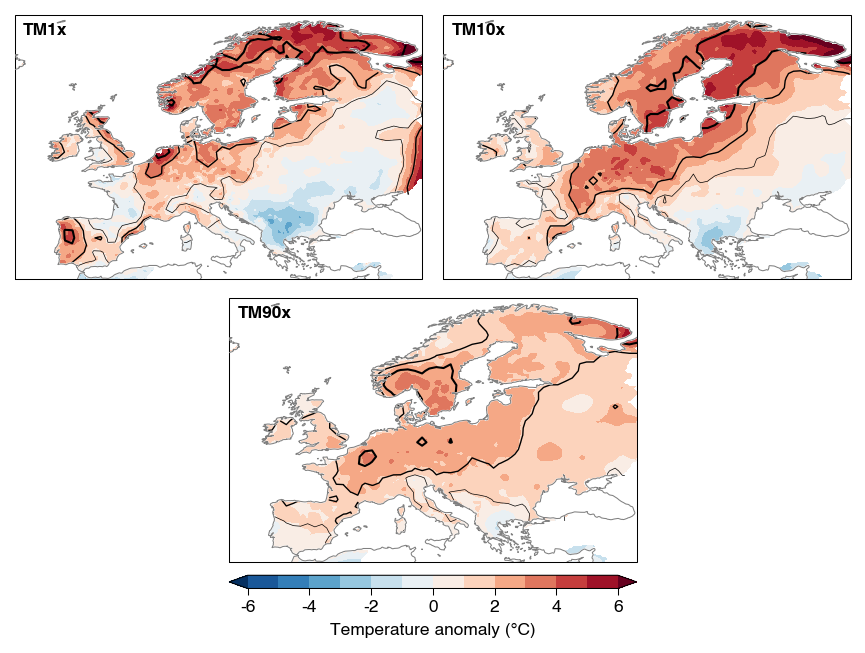

In [19]:
smooth_sigma = 4

fig = plt.figure()
gs = fig.add_gridspec(2,4,wspace=0.1,hspace=0.1)
ax = [fig.add_subplot(gs[0,:2],projection=crs.PlateCarree()),fig.add_subplot(gs[0,2:],projection=crs.PlateCarree()),fig.add_subplot(gs[1,1:3],projection=crs.PlateCarree())]

for i,metric in enumerate(['TX1av','TX10av','TX90av']):
    
    # plot maximum daily temp anomaly
    p=EObs.tg_anom.sel(time=2018,metric=metric).where(EObs.lsm).plot.contourf(ax=ax[i],cmap='RdBu_r',extend='both',levels=np.linspace(-6,6,13),transform=crs.PlateCarree(),add_colorbar=False)
    
    # plot sigma level
    EObs.tg_dt_sigma.sel(time=2018,metric=metric).where(EObs.lsm).coarsen(latitude=smooth_sigma,boundary='trim').mean().coarsen(longitude=smooth_sigma,boundary='trim').mean().plot.contour(ax=ax[i],levels=[0,1,2],colors='k',linewidths=[0.33,0.66,1],transform=crs.PlateCarree())
    
    ax[i].set_title('')
    ax[i].add_feature(cfeature.OCEAN,color='white',zorder=2)
    ax[i].coastlines('50m',color='grey',zorder=3,lw=0.5)
    ax[i].set_extent([-15, 42, 35,72], crs=crs.PlateCarree())
    ax[i].text(0.02,0.97,rename_metrics(metric),transform=ax[i].transAxes,va='top',ha='left',fontweight='bold',fontsize='small')

# colorbar
axins = ax[-1].inset_axes([0,-0.1,1,0.05],transform=ax[-1].transAxes)
cbar=plt.colorbar(p,cax=axins,extend='both',orientation='horizontal')
cbar.set_label('Temperature anomaly (\N{DEGREE SIGN}C)',fontsize='small')
cbar.ax.tick_params(axis='both',labelsize='small')

# fig layout
fig_aspect = 3/4
fig.patch.set_facecolor('xkcd:white')
fig.set_size_inches(textwidth,textwidth*fig_aspect)
fig.dpi=150
gs.tight_layout(fig,pad=1)

## save to Thesis directory
[fig.savefig('/home/leachl/Documents/Thesis/Ch1/Figures/Fig1.1.'+x, dpi=600) for x in ['pdf','png']]
''